<a href="https://colab.research.google.com/github/goncalobv/ml-experiments/blob/main/Interpretability_Saliency_and_Class_Activation_Maps_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The experiments below might reuse some code from the MIT course on Introduction to Deep Learning, released uder the MIT license:

# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Saliency and Class Activation Maps on MNIST dataset
In this notebook, we modify code from one of the labs in [Intro to Deep Learning](http://introtodeeplearning.com/) to apply Saliency and Class Activation Maps (SmoothGrad, GradCAM, GradCAM++ and ScoreCAM/Faster-ScoreCAM) from tf-keras-vis. We follow a similar approach as shown in [tf-keras-vis attention](https://github.com/keisen/tf-keras-vis/blob/ddd951396f16e7f5b7a0e8619f43f99c599628fb/examples/attentions.ipynb) example, but applying to the MNIST dataset. Some text blocks are also copied over.

For a mathematical explanation of these methods, consult the [pixel attribution](https://christophm.github.io/interpretable-ml-book/pixel-attribution.html) section of the Interpretable Machine Learning book.

Other libraries that provide interpretability methods for Tensorflow:
- [iNNvestigate](https://github.com/albermax/innvestigate)
- [DeepExplain toolbox](https://github.com/marcoancona/DeepExplain)


A few other pointers on network interpretability:
- [Understanding CNNs](https://cs231n.github.io/understanding-cnn/)
- [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb#scrollTo=9Rvhpqtn3XXm)
- [Feature visualization in GoogLeNet](https://distill.pub/2017/feature-visualization/)
- [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)


In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

!pip install tf-keras-vis

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.float32)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.float32)

nr_classes = 10

train_labels_cat = tf.keras.utils.to_categorical(train_labels, nr_classes)
test_labels_cat = tf.keras.utils.to_categorical(test_labels, nr_classes)

# Get 10 samples of the 10 classes (got from training example, no special reason)
sample_inputs = []
for i in np.arange(nr_classes):
  sample_inputs.append(train_images[train_labels == i][0])

sample_inputs = np.reshape(sample_inputs, (10, 28, 28, 1))

subplot_args = { 'nrows': 1, 'ncols': 10, 'figsize': (30, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

# Helper to render images
def renderImages(images, heatmap=[], cmap=plt.cm.binary):
  f, ax = plt.subplots(**subplot_args)
  for i in np.arange(len(images)):
      ax[i].set_title(i, fontsize=14)
      ax[i].imshow(images[i], cmap=cmap)
      if len(heatmap) > 0:
        # Add heatmap overlay
        ax[i].imshow(heatmap[i], cmap='jet', alpha=0.5)
  plt.tight_layout()
  plt.show()


## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

In [ ]:
# Define a very simple fully connected model
def build_fc_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# CNN as presented in the Intro to Deep Learning lab
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu'), 
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Conv2D(filters=36, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return cnn_model
# Simpler CNN matching https://github.com/keisen/tf-keras-vis/blob/master/examples/visualize_dense_layer.ipynb
def build_simple_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'), 
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    return cnn_model

# Select one of the 3 neural networks to train
#model = build_fc_model()
#model = build_cnn_model()
model = build_simple_cnn_model()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy']) # TODO

model.fit(train_images, train_labels_cat, batch_size=128, epochs=25, validation_split = 0.2, verbose=1)

test_loss, test_acc = model.evaluate(test_images, test_labels_cat)

print('Test accuracy:', test_acc)

Epoch 1/25
375/375 [==============================] - 3s 4ms/step - loss: 0.4592 - accuracy: 0.8644 - val_loss: 0.0875 - val_accuracy: 0.9758
Epoch 2/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0817 - accuracy: 0.9763 - val_loss: 0.0641 - val_accuracy: 0.9815
Epoch 3/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.0544 - val_accuracy: 0.9843
Epoch 4/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0361 - accuracy: 0.9889 - val_loss: 0.0487 - val_accuracy: 0.9857
Epoch 5/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0514 - val_accuracy: 0.9843
Epoch 6/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.0507 - val_accuracy: 0.9858
Epoch 7/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.0482 - val_accuracy: 0.9879
Epoch 

# Saliency Maps: applying gradient (Saliency Maps)
Saliency map corresponds to pixels in the input that were most relevant for the classification by the neural network. Saliency maps then consist in the input regions for which a change in the input value mostly contribute to a change on the loss or the output value. For the simpler networks (i) and (ii), we notice that the saliency maps are not very meaningful. For network (iii), the saliency map is slightly more interesting, though the features are still very coarse.

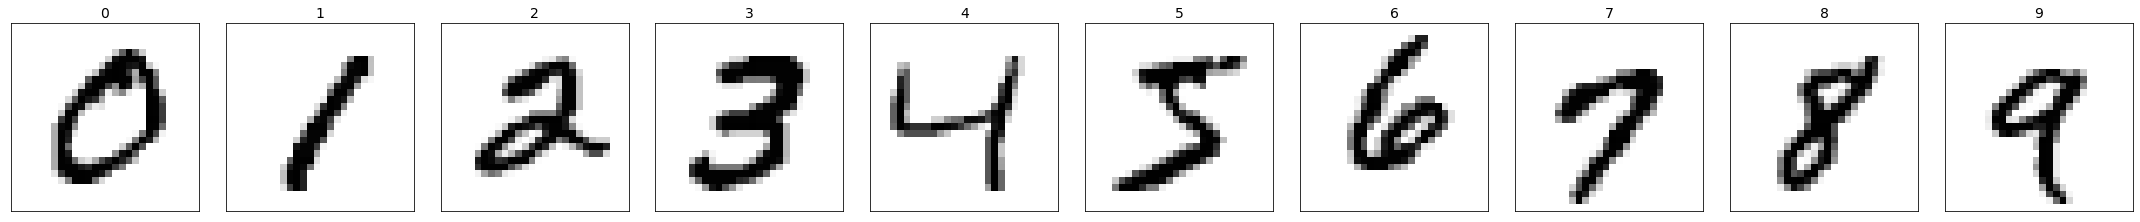

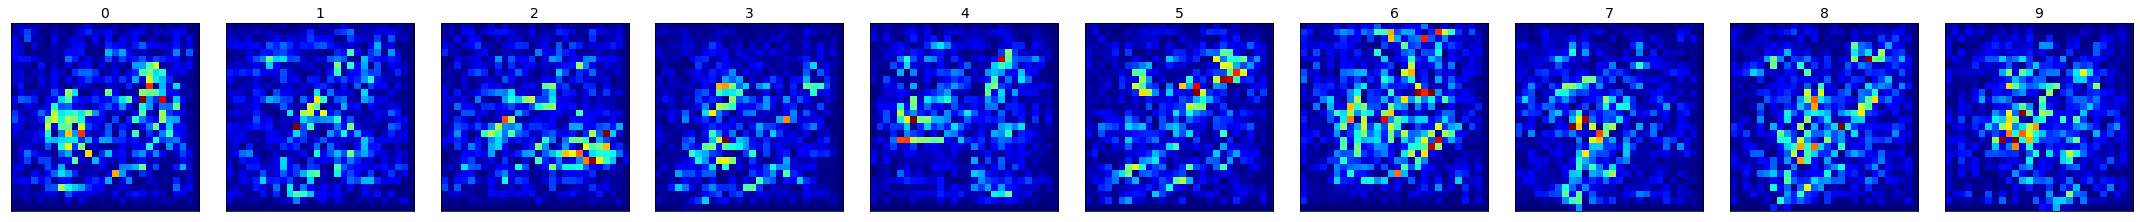

In [ ]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print
from tf_keras_vis.utils.input_modifiers import Jitter, Rotate
from tf_keras_vis.utils.regularizers import L2Norm, TotalVariation
from tf_keras_vis.utils.callbacks import OptimizerCallback

from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize


def loss(output):
  # For seed input i, maximize prediction of class output j
  return [output[i, j] for (i,j) in enumerate(np.arange(nr_classes))]
    

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear


saliency = Saliency(model,
                    model_modifier=model_modifier)

# Generate saliency map
saliency_map = saliency(loss, sample_inputs)
saliency_map = normalize(saliency_map)

# Render input images
renderImages(sample_inputs[:,:,:,0])

# Render saliency images
renderImages(saliency_map, cmap='jet')

# Saliency Maps: applying SmoothGrad
SmoothGrad is a method that reduces noise of saliency maps by adding noise to input images.

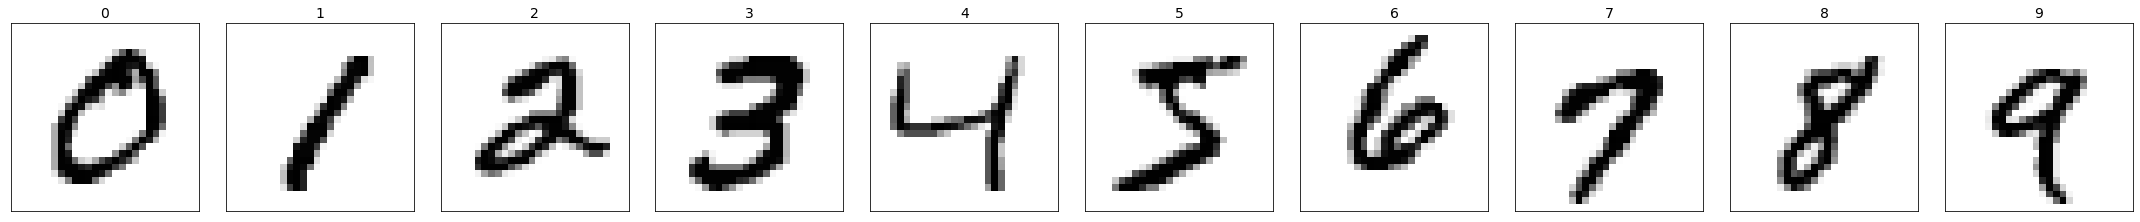

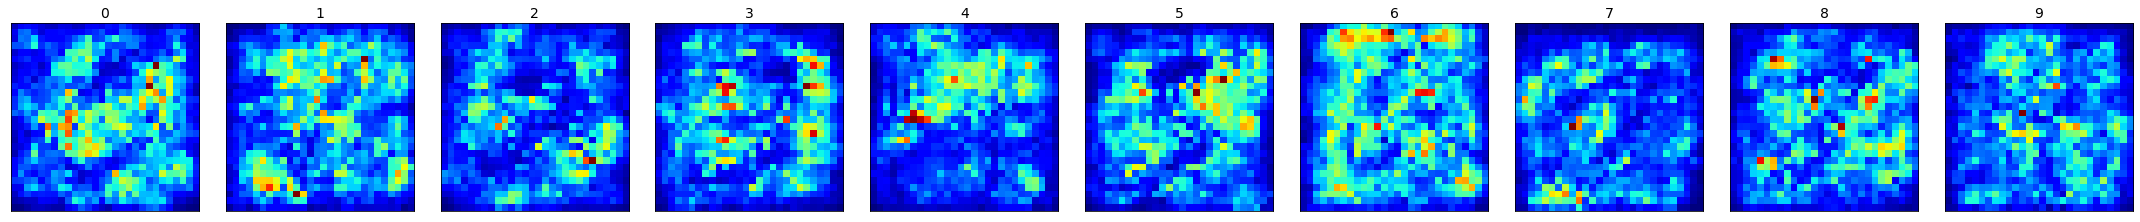

In [ ]:
saliency = Saliency(model,
                    model_modifier=model_modifier)


# Generate saliency map
# No significant changes, by editing smooth_samples or smooth_noise
# Lower smooth noise, the closest to vanilla saliency
saliency_map = saliency(loss,
                        sample_inputs,
                        smooth_samples=20,
                        smooth_noise=0.20)

saliency_map = normalize(saliency_map)

# Render input images
renderImages(sample_inputs[:,:,:,0])

# Render saliency images
renderImages(saliency_map, cmap='jet')

# Class Activation Maps: Applying GradCAM

Another way of visualizing attention is GradCAM. Instead of using gradients with respect to model outputs, it uses the penultimate (pre Dense layer) Convolutional layer output.

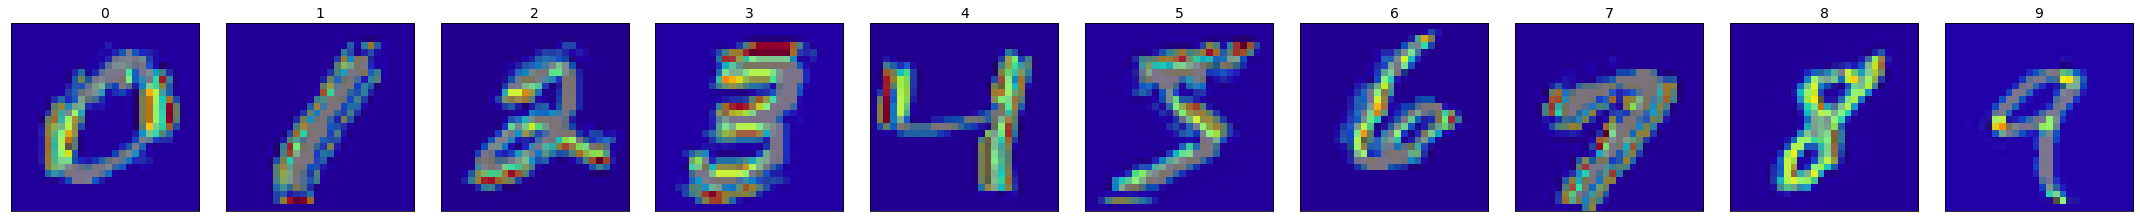

In [ ]:

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              sample_inputs,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
renderImages(sample_inputs[:,:,:,0], heatmap, cmap=None)


# Class Activation Maps: Applying GradCAM++

GradCAM++ improves the application of GradCAM by expanding the attention to a larger portion of the input features. We notice that the input images digit pixels are better covered with GradCAM++.

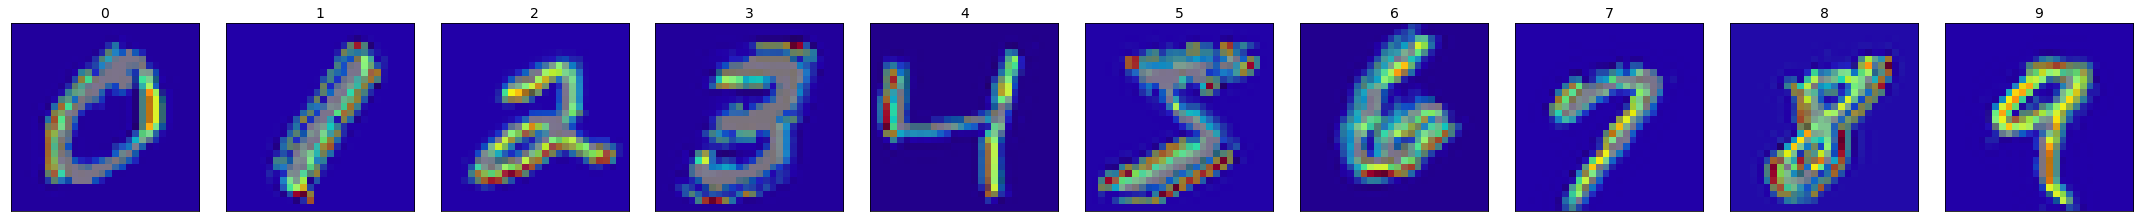

In [ ]:
from tf_keras_vis.gradcam import GradcamPlusPlus

# Create GradCAM++ object, Just only repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model, model_modifier, clone=False)
gradcam = GradcamPlusPlus(model,
                          model_modifier)

# Generate heatmap with GradCAM++
cam = gradcam(loss,
              sample_inputs,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
renderImages(sample_inputs[:,:,:,0], heatmap, cmap=None)


# Class Activation Maps: applying ScoreCAM
ScoreCAM is a gradient-free CAM method, though computationally expensive. Only consider when running on a GPU.

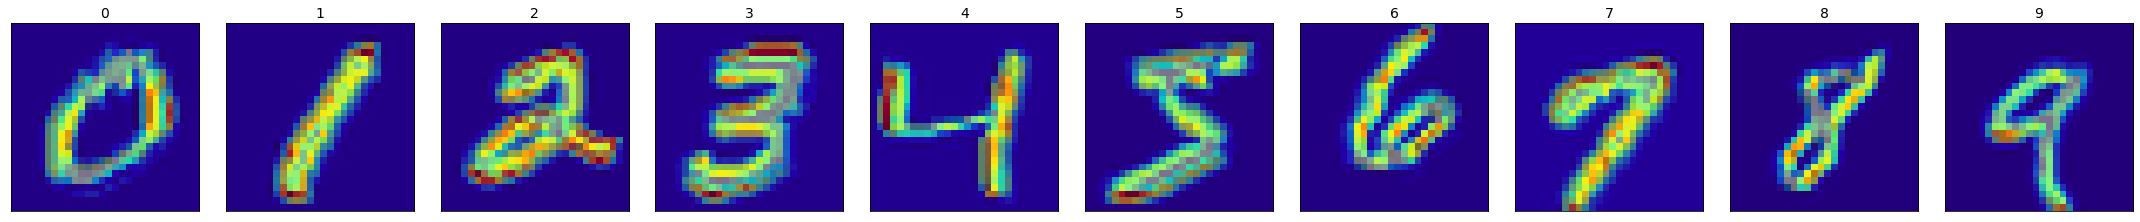

In [ ]:
from tf_keras_vis.scorecam import ScoreCAM

# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier)

# Only run ScoreCAM on GPU
if len(tf.config.list_physical_devices('GPU')) > 0:
    # Generate heatmap with ScoreCAM
    cam = scorecam(loss,
                   sample_inputs,
                   penultimate_layer=-1, # model.layers number
                  )
    cam = normalize(cam)

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    renderImages(sample_inputs[:,:,:,0], heatmap, cmap=None)

else:
    print("No GPUs available. ScoreCAM takes a long time to run on CPUs - consider running Faster-ScoreCAM")

# Class Activation Maps: applying Faster ScoreCAM

Extracted from [the official repo](https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam):
> We thought that several channels were dominant in generating the final heat map. Faster-Score-CAM adds the processing of “use only channels with large variances as mask images” to Score-CAM. (max_N = -1 is the original Score-CAM).



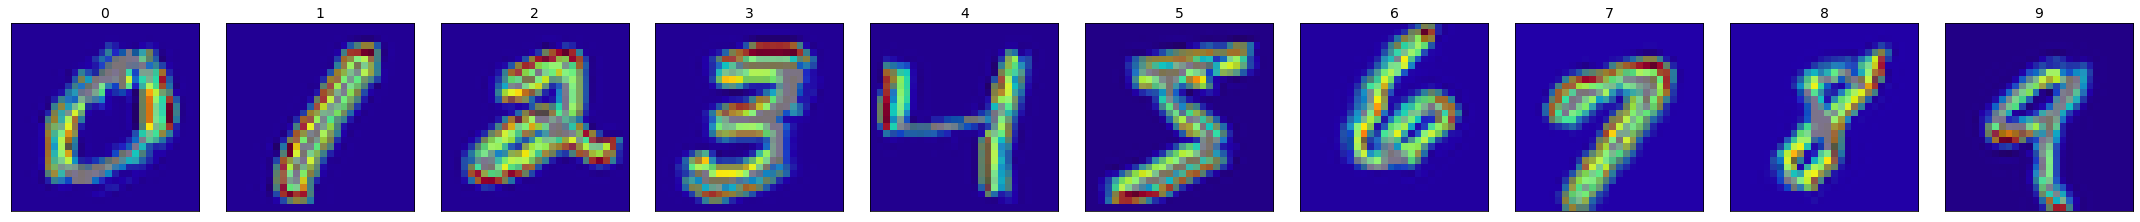

In [ ]:
# Create ScoreCAM object
scorecam = ScoreCAM(model, model_modifier)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(loss,
               sample_inputs,
               penultimate_layer=-1, # model.layers number
               max_N=10
              )
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
renderImages(sample_inputs[:,:,:,0], heatmap, cmap=None)
